In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sctoolbox
from sctoolbox import settings
from sctoolbox.utilities import bgcolor

# Trajectory and Pseudotime Analysis
<hr style="border:2px solid black"> </hr>

## 1 - Description
### 1.1 - Pseudotime Analysis
For pseudotime ordering (or trajectory interference) cells are ordered along a continuous path based on their difference in gene expression. This differs from the velocity analysis which uses the rate of unspliced and spliced mRNAs.  
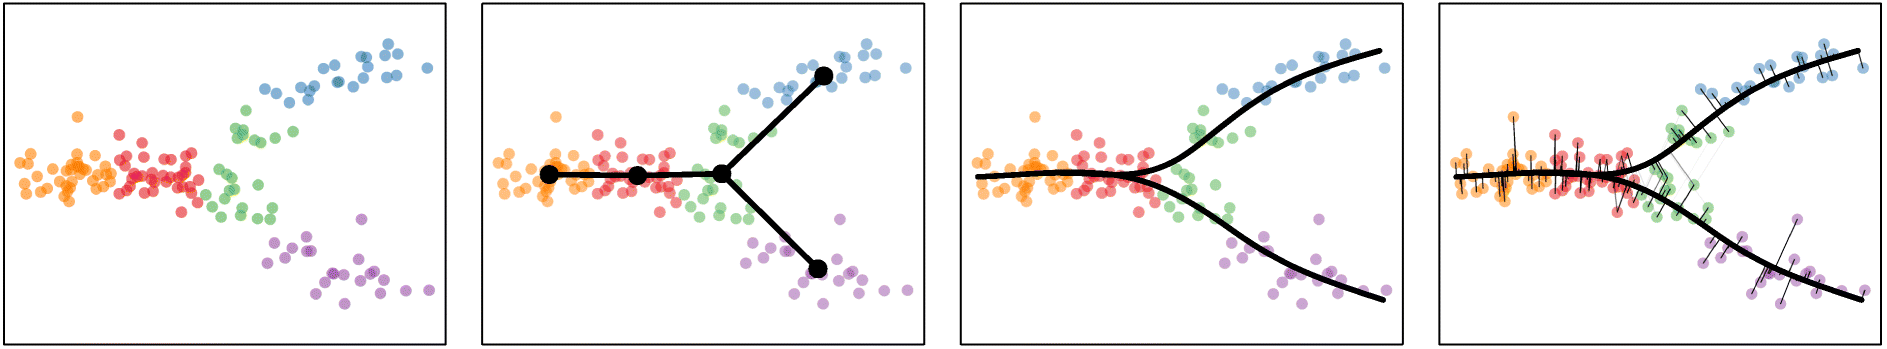
<span style="color:lightgrey">Image source: https://en.wikipedia.org/wiki/Trajectory_inference</span>.

This notebook can be used for trajectory analysis of scRNA data using the scFates package.  
Most analysis steps are directly taken from the scFates <a href=https://scfates.readthedocs.io/en/latest/Tree_Analysis_Bone_marrow_fates.html>documentation</a>

### 1.2 - Parameters
| Parameter | Description | Options |
|:---:|:---|:---|
| graph | Type of the principal graph, a "curve" for a basic linear curve or "tree" for a more complex trajectory | "curve",  "tree"|
| nodes | Number of nodes composing the principial tree, use a range of 10 to 100 for ElPiGraph approach and 100 to 2000 for PPT approach. | int |
| ndims_rep | Number of dimensions to use for the inference | int |
| method | principal graph algorithm for tree inference | "ppt", "epg" |
| ppt_sigma | Regularization parameter for simpleppt (method='ppt') algorithm | float, int |
| ppt_lambda | penalty for the tree length | float, int |
| epg_lambda | Parameter for ElPiGraph, coefficient of ‘stretching’ elasticity.| float, int |
| epg_mu | Parameter for ElPiGraph, coefficient of ‘bending’ elasticity. | float, int |
| n_map | number of probabilistic mapping of cells onto the tree to use. If n_map=1 then likelihood cell mapping is used. | int |
| n_threads | Number of cpu processes to use in case of performing multiple mapping. | int |

___

## 2 - Input/output settings

In [ ]:
%bgcolor PowderBlue

# In/output paths
settings.adata_input_dir = "../adatas/"
settings.adata_output_dir = "../adatas/pseudotime/"
settings.figure_dir = '../figures/pseudotime/'
settings.log_file: "../logs/pseudotime_analysis_log.txt"

# Input/Output
last_notebook_adata = "anndata_4.h5ad"
output = "anndata_pseudotime.h5ad"

___

## 3 - Loading packages

In [ ]:
import scanpy as sc
import pandas as pd
import sctoolbox.utilities as utils
import sctoolbox.plotting as pl

## scFates
import scFates as scf

sc.set_figure_params(vector_friendly=True, dpi_save=300, scanpy=False)

___

## 4 - Load anndata

In [ ]:
adata = utils.load_h5ad(last_notebook_adata)

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

___

## 5 - scFates
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [ ]:
%bgcolor PowderBlue


### scFates parameters ###
seed = 1

# Column containing final clustering
clustering = "clustering"
# Embedding pca/umap/tsne...
embedding = "umap"
graph = "tree"  # can be "curve" for a basic linear curve or "tree" for a more complex trajectory
nodes = 100  # number of nodes for the principal graph, if None, number of nodes will be automatically infered based on the number of cells
             # use a range of 10 to 100 for ElPiGraph (epg) approach and 100 to 2000 for PPT approach
ndims_rep = 2  # Number of dimensions to use for the inference
method = "ppt"  # principal graph algorithm for tree inference, "ppt" or "epg"
## PPT ##
ppt_sigma = None  # Regularization parameter for simpleppt (method='ppt') algorithm, if None, it will be infered automatically
ppt_lambda = 100  # Parameter for simpleppt (method='ppt'), penalty for the tree length 
## EPG ##
epg_lambda=0.01
epg_mu=0.1

n_map = 10  # number of probabilistic mapping of cells onto the tree to use. If n_map=1 then likelihood cell mapping is used
n_threads = 4

----------

### 5.1 - Calculate Graph

In [ ]:
if nodes is None:
    if adata.shape[0] * 2 > 100:
        nodes = 100
    else:
        nodes = int(adata.shape[0] / 2)

if graph == 'curve':
    scf.tl.curve(adata, Nodes=nodes, use_rep=f"X_{embedding}", ndims_rep=ndims_rep, seed=seed)

elif graph == 'tree':
    if method == 'ppt':
        if ppt_sigma is None:
            ppt_sigma = scf.tl.explore_sigma(adata,
                                             Nodes=nodes,
                                             use_rep=embedding,
                                             sigmas=[1000, 100, 10, 1, 0.1, 0.025, 0.01],
                                             plot=False, second_round=True)

            print(f"Sigma value for 'ppt' is None! Automatic value is calculated: simga = {ppt_sigma}")

    print(f"Algorithm used: {method}\n")
    scf.tl.tree(adata, method=method, Nodes=nodes, use_rep=embedding,
                ppt_lambda=ppt_lambda, ppt_sigma=ppt_sigma, ppt_nsteps=50, seed=seed)

----------

### 5.2 - Plot graph
* A principal graph infered from the embedding. Cells are assigned to a node by a value between 0 and 1, which allow us to use probabilistic mappings to account for variability.

In [ ]:
scf.pl.graph(adata, basis=embedding, color_cells=clustering, alpha=0.2, show=False)
pl._save_figure(f"trajectory_{graph}_{embedding}.pdf")

----------

### 5.3 - Pseudotime

#### Note!
The pseudotime analysis requires a starting point (root), considered as the earliest time point. Thus, you need to specify a root node to proceed. Using this node, the pseudotime will be calculated as the distance of each node to the root node.

**Choose a root node in the marked cell below.** There are three options on what the root node could be:
    
1. Select a node by ID. By observing the graph above a suitable node can be picked by choosing one of the displayed node IDs.
2. Select a gene as root. Provide a gene of interest, where the highest expression will be considered root.
3. Automatic node detection based on a cell (`.obs`) measurement. Select a `.obs` column by name that contains numeric values e.g. the expression of a specific gene or a set of genes.

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [ ]:
%bgcolor PowderBlue

# choose a root for the pseudotime analysis; The root can either be:
# -> Node ID from the graph above (int)
# -> Gene name to derive pseudotime based on it's expression (str)
# You can also use a column in .obs with continuous values to calculate pseudotime based on these values (str)
# Example: root = 1, root = 'gene name', root = 'obs_column'
root = 0

----------

In [ ]:
if type(root) not in [str, int]:
    raise TypeError("Invalid root! please provide either a node ID (int), gene name (str) or .obs columns (str)")
if type(root) == str:
    if root not in adata.obs.columns and root not in adata.var_names:
        raise ValueError("String was not found in adata.obs or adata.var! Please provide a valid obs column or gene name")
    if root in adata.obs.columns:
        if adata.obs[root].dtypes not in ["float32", "float64", "int32", "int64"]:
            raise TypeError("Given .obs column should contain continuous values! Please provide a valid column")

In [ ]:
scf.tl.root(adata, root=root)

try:
    scf.tl.pseudotime(adata, n_jobs=n_threads, n_map=n_map, seed=seed)
except ValueError:
    # sometimes multiple mapping result in some unmapped cells, this could be caused by poor quality
    # of the calculated graph due to poor parameter choice!
    print("Number of cell mapping will be reduced to 1! Consider modifiying and re-running the graph calculation to get more robust results\n")
    scf.tl.pseudotime(adata, n_jobs=1, n_map=1, seed=seed)

----------

### 5.4 - Plot Trajectory graph

In [ ]:
scf.pl.trajectory(adata, basis=embedding, scale_path=0.25, color_cells=clustering,
                  alpha=0.2, arrows=True, show=False)
pl._save_figure(f"pseudotime_trajectory_{embedding}.pdf", dpi=300)

----------

### 5.5 - Plot pseudotime
- __seg__: Each cell is assigned to a segment (seg) based on distance to root.
- __milestones__: highlight the forks and tips
- __t__: pseudotime values

In [ ]:
pl.plot_embedding(adata, method=embedding, color=["seg", "milestones", "t", clustering], ncols=2, show=False)
pl._save_figure(f"trajectory_tree_segments_{embedding}.pdf")

----------

### 5.6 - Plot dendogram

plotting a dendogram showing branching of segments along the pseudotime

In [ ]:
# calculate dendogram
if graph == 'tree':
    scf.tl.dendrogram(adata, n_jobs=n_threads)
    scf.pl.dendrogram(adata, color=["seg"], show=False)
    pl._save_figure("trajectory_tree_segments_dendogram.pdf")

----------

## 6 - Saving adata

In [ ]:
utils.save_h5ad(adata, output)

In [ ]:
settings.close_logfile()